In [186]:
import pandas as pd
import numpy as np
import librosa
import torch
import copy
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler

In [140]:
num_classes = 2
batch = 100
num_epochs = 10
learning_rate = 0.0001

In [141]:
def output_label(label):
    output_mapping = {
                 0: "Not Prog Rock",
                 1: "Prog rock"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# Data information

Shape of spectrogram.npz is (7966, 128, 431)

Shape of chromagram.npz is (7966, 12, 431)

Shape of mfcc.npz is (7966, 20, 431)

Shape of tempogram_fourier is (7966, 193, 432)

Shape of tempogram_local_auto is (7966, 384, 431)


# Data Shuffler

In [142]:
y = np.load('labels.npy')
total_samples = data.shape[0]
all_indices = [i for i in range(total_samples)]
np.random.seed(27)
np.random.shuffle(all_indices,)
train_percentage=50
train_size = int(7966/2)
y_train = []
y_test = []
for indice in all_indices[:train_size]:
    y_train.append(y[indice])
for indice in all_indices[train_size:]:
    y_test.append(y[indice])
y_train = np.array(y_train)
y_test = np.array(y_test)

labels_save_array = []
for i in range(y_train.shape[0]):
    labels_save_array.append(y_train[i])
for i in range(y_test.shape[0]):
    labels_save_array.append(y_test[i])
labels_save_array = np.array(labels_save_array)

# Modeling with Spectrograms

In [143]:
data = np.load('spectrogram.npz')['arr_0']
x_dim = data.shape[1]
y_dim = data.shape[2]

X_train = []
X_test = []
for indice in all_indices[:train_size]:
    X_train.append(data[indice])
for indice in all_indices[train_size:]:
    X_test.append(data[indice])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

tensor_X_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_train=tensor_y_train.long()

traindataset = TensorDataset(tensor_X_train,tensor_y_train)
trainloader = DataLoader(traindataset,batch_size=batch,shuffle=False)

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(y_test)
tensor_y_test=tensor_y_test.long()


testdataset = TensorDataset(tensor_X_test,tensor_y_test)
testloader = DataLoader(testdataset,batch_size=batch,shuffle=False)

In [144]:
class SpectrogramCNN(nn.Module):   
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*14*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

#Code to pull the intermediary layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [145]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device", device)
print("batch_size:",batch)
print("number of epochs:",num_epochs)
print("learning rate:",learning_rate)
print("optimizer:","Adam")
print("Loss function","Cross Entropy Loss")
model = SpectrogramCNN()
model.to(device)
model.fc1.register_forward_hook(get_activation('fc1'))
# model.fc2.register_forward_hook(get_activation('fc2'))
# model.layer4.register_forward_hook(get_activation('layer4'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


for epoch in range(num_epochs):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        #print(labels)
    
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
    
    print("Epoch: {}, Loss: {:.7f}".format(epoch, loss.data))

Device mps
batch_size: 100
number of epochs: 10
learning rate: 0.0001
optimizer: Adam
Loss function Cross Entropy Loss
SpectrogramCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=45696, out_features=2, bias=True)
  )
)
Epoch: 0, Loss: 0.5375202
Epoch: 1, Loss: 0.5241039
Epoch: 2, Loss: 0.4575893
Epoch: 3, Loss: 0.4079357
Epoch: 4, Loss: 0.3630989
Epoch: 5, Loss: 0.3227904
Epoch: 6, Loss: 0.2945292
Epoch: 7, Loss: 0.2495717
Epoch: 8

# Saving model

In [146]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, './spectrogram.pth')

# Training Accuracy

In [147]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1


print("Train Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Train Set Accuracy
Accuracy of Not Prog Rock: 74.40%
Accuracy of Prog rock: 98.49%


# Saving output of fully connected layer and Test Accuracy

In [148]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# Saving different layer outputs

output_train_fc1 = []
for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(train)
        output_train_fc1.append(activation["fc1"])
        

output_test_fc1 = []
for images, labels in testloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        output_test_fc1.append(activation["fc1"])


print("Test Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Test Set Accuracy
Accuracy of Not Prog Rock: 54.92%
Accuracy of Prog rock: 93.92%


In [149]:
all_outputs=[]
for j in range(len(output_train_fc1)):
    for i in range(len(output_train_fc1[j])):
        all_outputs.append(np.array(output_train_fc1[j].detach().cpu()[i]))
for j in range(len(output_test_fc1)):
    for i in range(len(output_test_fc1[j])):
        all_outputs.append(np.array(output_test_fc1[j].detach().cpu()[i]))
all_outputs=np.array(all_outputs)

df_spectrogram=pd.DataFrame(data=all_outputs)
column_dict = {}
for i in range(2):
    column_dict[i]='Feature{}'.format(i+1)
df_spectrogram=df_spectrogram.rename(columns=column_dict)

In [150]:
df_spectrogram

,Feature1,Feature2
0,0.573465,-0.921595
1,0.258623,0.294131
2,-1.577313,3.604646
3,-0.026562,-0.788662
4,0.736023,-0.375732
...,...,...
7961,-1.026285,1.126576
7962,0.909533,-0.322924
7963,0.095035,0.231692
7964,-0.686978,1.807584


In [151]:
df_spectrogram['label']=labels_save_array

In [152]:
df_spectrogram.to_csv('spectrogram.csv',index=False)

# Modeling with Chromagrams

In [153]:
data = np.load('chromagram.npz')['arr_0']
x_dim = data.shape[1]
y_dim = data.shape[2]

X_train = []
X_test = []
for indice in all_indices[:train_size]:
    X_train.append(data[indice])
for indice in all_indices[train_size:]:
    X_test.append(data[indice])
X_train = np.array(X_train)
X_test = np.array(X_test)


tensor_X_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_train=tensor_y_train.long()

traindataset = TensorDataset(tensor_X_train,tensor_y_train)
trainloader = DataLoader(traindataset,batch_size=batch,shuffle=False)

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(y_test)
tensor_y_test=tensor_y_test.long()


testdataset = TensorDataset(tensor_X_test,tensor_y_test)
testloader = DataLoader(testdataset,batch_size=batch,shuffle=False)

In [154]:
class ChromagramCNN(nn.Module):   
    def __init__(self):
        super(ChromagramCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5), padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*12*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

#Code to pull the intermediary layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [155]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device", device)
print("batch_size:",batch)
print("number of epochs:",num_epochs)
print("learning rate:",learning_rate)
print("optimizer:","Adam")
print("Loss function","Cross Entropy Loss")
model = ChromagramCNN()
model.to(device)
model.fc1.register_forward_hook(get_activation('fc1'))
# model.fc2.register_forward_hook(get_activation('fc2'))
# model.layer4.register_forward_hook(get_activation('layer4'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


for epoch in range(50):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        #print(labels)
    
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        #print(train.shape)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
    if epoch==49:
        print("Epoch: {}, Loss: {:.7f}".format(epoch, loss.data))

Device mps
batch_size: 100
number of epochs: 10
learning rate: 0.0001
optimizer: Adam
Loss function Cross Entropy Loss
ChromagramCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=39168, out_features=2, bias=True)
  )
)
Epoch: 49, Loss: 0.2067152


# Saving Model

In [156]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, './chromagram.pth')

# Training Accuracy

In [157]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1


print("Train Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Train Set Accuracy
Accuracy of Not Prog Rock: 91.44%
Accuracy of Prog rock: 96.29%


# Saving output of fully connected layer and Test Accuracy

In [158]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# Saving different layer outputs

output_train_fc1 = []
for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(train)
        output_train_fc1.append(activation["fc1"])
        

output_test_fc1 = []
for images, labels in testloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        output_test_fc1.append(activation["fc1"])


print("Test Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Test Set Accuracy
Accuracy of Not Prog Rock: 57.42%
Accuracy of Prog rock: 76.23%


In [159]:
all_outputs=[]
for j in range(len(output_train_fc1)):
    for i in range(len(output_train_fc1[j])):
        all_outputs.append(np.array(output_train_fc1[j].detach().cpu()[i]))
for j in range(len(output_test_fc1)):
    for i in range(len(output_test_fc1[j])):
        all_outputs.append(np.array(output_test_fc1[j].detach().cpu()[i]))
all_outputs=np.array(all_outputs)

df_chromagram=pd.DataFrame(data=all_outputs)
# column_dict = {}
# for i in range(3,5):
#     column_dict[i]='Feature{}'.format(i+1)
# df_chromagram=df_chromagram.rename(columns=column_dict)

In [160]:
df_chromagram

,0,1
0,1.320225,-1.390412
1,0.656168,-0.475169
2,-2.199626,1.992025
3,1.348634,-1.487818
4,1.147982,-0.426968
...,...,...
7961,-0.443271,0.463939
7962,0.321434,-0.496746
7963,-0.791881,0.606543
7964,-1.140626,1.351388


In [161]:
df_chromagram['label']=labels_save_array
df_chromagram.to_csv('chromagram.csv',index=False)

# Modeling with MFCCs

In [162]:
data = np.load('mfcc.npz')['arr_0']
x_dim = data.shape[1]
y_dim = data.shape[2]

X_train = []
X_test = []
for indice in all_indices[:train_size]:
    X_train.append(data[indice])
for indice in all_indices[train_size:]:
    X_test.append(data[indice])
X_train = np.array(X_train)
X_test = np.array(X_test)


tensor_X_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_train=tensor_y_train.long()

traindataset = TensorDataset(tensor_X_train,tensor_y_train)
trainloader = DataLoader(traindataset,batch_size=batch,shuffle=False)

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(y_test)
tensor_y_test=tensor_y_test.long()


testdataset = TensorDataset(tensor_X_test,tensor_y_test)
testloader = DataLoader(testdataset,batch_size=batch,shuffle=False)

In [163]:
class MfccCNN(nn.Module):   
    def __init__(self):
        super(MfccCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5), padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*20*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

#Code to pull the intermediary layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [164]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device", device)
print("batch_size:",batch)
print("number of epochs:",num_epochs)
print("learning rate:",learning_rate)
print("optimizer:","Adam")
print("Loss function","Cross Entropy Loss")
model = MfccCNN()
model.to(device)
model.fc1.register_forward_hook(get_activation('fc1'))
# model.fc2.register_forward_hook(get_activation('fc2'))
# model.layer4.register_forward_hook(get_activation('layer4'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


for epoch in range(10):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        #print(labels)
    
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        #print(train.shape)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
    #if epoch==49:
    print("Epoch: {}, Loss: {:.7f}".format(epoch, loss.data))

Device mps
batch_size: 100
number of epochs: 10
learning rate: 0.0001
optimizer: Adam
Loss function Cross Entropy Loss
MfccCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=65280, out_features=2, bias=True)
  )
)
Epoch: 0, Loss: 0.5238191
Epoch: 1, Loss: 0.4892946
Epoch: 2, Loss: 0.3969509
Epoch: 3, Loss: 0.3362081
Epoch: 4, Loss: 0.2604139
Epoch: 5, Loss:

# Saving model

In [165]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, './mfcc.pth')

# Training Accuracy

In [166]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1


print("Train Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Train Set Accuracy
Accuracy of Not Prog Rock: 93.53%
Accuracy of Prog rock: 98.82%


# Saving output of fully connected layer and test accuracy

In [167]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# Saving different layer outputs

output_train_fc1 = []
for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(train)
        output_train_fc1.append(activation["fc1"])
        

output_test_fc1 = []
for images, labels in testloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        output_test_fc1.append(activation["fc1"])


print("Test Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Test Set Accuracy
Accuracy of Not Prog Rock: 68.41%
Accuracy of Prog rock: 88.80%


In [168]:
all_outputs=[]
for j in range(len(output_train_fc1)):
    for i in range(len(output_train_fc1[j])):
        all_outputs.append(np.array(output_train_fc1[j].detach().cpu()[i]))
for j in range(len(output_test_fc1)):
    for i in range(len(output_test_fc1[j])):
        all_outputs.append(np.array(output_test_fc1[j].detach().cpu()[i]))
all_outputs=np.array(all_outputs)

df_mfcc=pd.DataFrame(data=all_outputs)
# column_dict = {}
# for i in range(5,7):
#     column_dict[i]='Feature{}'.format(i+1)
# df_mfcc=df_mfcc.rename(columns=column_dict)

In [169]:
df_mfcc

,0,1
0,2.059067,-1.699888
1,1.057308,-1.669801
2,-11.311894,12.829426
3,1.365380,-0.524324
4,0.275750,-0.415322
...,...,...
7961,-0.105682,-0.168393
7962,1.484818,-1.296433
7963,1.550550,-1.507257
7964,0.271451,0.290763


In [170]:
df_mfcc['label']=labels_save_array
df_mfcc.to_csv('mfcc.csv',index=False)

# Modeling with Fourier Tempogram

In [171]:
data = np.load('tempogram_fourier.npz')['arr_0']
x_dim = data.shape[1]
y_dim = data.shape[2]

X_train = []
X_test = []
for indice in all_indices[:train_size]:
    X_train.append(data[indice])
for indice in all_indices[train_size:]:
    X_test.append(data[indice])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

tensor_X_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_train=tensor_y_train.long()

traindataset = TensorDataset(tensor_X_train,tensor_y_train)
trainloader = DataLoader(traindataset,batch_size=batch,shuffle=False)

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(y_test)
tensor_y_test=tensor_y_test.long()


testdataset = TensorDataset(tensor_X_test,tensor_y_test)
testloader = DataLoader(testdataset,batch_size=batch,shuffle=False)

In [172]:
class FourierCNN(nn.Module):   
    def __init__(self):
        super(FourierCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*22*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

#Code to pull the intermediary layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [173]:
data.shape

(7966, 193, 432)

In [174]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device", device)
print("batch_size:",batch)
print("number of epochs:",num_epochs)
print("learning rate:",learning_rate)
print("optimizer:","Adam")
print("Loss function","Cross Entropy Loss")
model = FourierCNN()
model.to(device)
model.fc1.register_forward_hook(get_activation('fc1'))
# model.fc2.register_forward_hook(get_activation('fc2'))
# model.layer4.register_forward_hook(get_activation('layer4'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


for epoch in range(10):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        #print(labels)
    
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        #print(train.shape)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
    #if epoch==49:
    print("Epoch: {}, Loss: {:.7f}".format(epoch, loss.data))

Device mps
batch_size: 100
number of epochs: 10
learning rate: 0.0001
optimizer: Adam
Loss function Cross Entropy Loss
FourierCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=71808, out_features=2, bias=True)
  )
)
Epoch: 0, Loss: 0.5637505
Epoch: 1, Loss: 0.5167858
Epoch: 2, Loss: 0.4346141
Epoch: 3, Loss: 0.3907695
Epoch: 4, Loss: 0.3576892
Epoch: 5, Loss: 0.3479774
Epoch: 6, Loss: 0.3257057
Epoch: 7, Loss: 0.3113381
Epoch: 8, Lo

# Saving model

In [175]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, './fourier_tempogram.pth')

# Training Accuracy

In [176]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1


print("Train Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Train Set Accuracy
Accuracy of Not Prog Rock: 78.25%
Accuracy of Prog rock: 94.00%


# Saving output of fully connected layer and test accuracy

In [177]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# Saving different layer outputs

output_train_fc1 = []
for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(train)
        output_train_fc1.append(activation["fc1"])
        

output_test_fc1 = []
for images, labels in testloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        test = images.view(images.shape[0], 1, x_dim, y_dim)
        outputs = model(test)
        output_test_fc1.append(activation["fc1"])


print("Test Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Test Set Accuracy
Accuracy of Not Prog Rock: 58.95%
Accuracy of Prog rock: 86.65%


In [178]:
all_outputs=[]
for j in range(len(output_train_fc1)):
    for i in range(len(output_train_fc1[j])):
        all_outputs.append(np.array(output_train_fc1[j].detach().cpu()[i]))
for j in range(len(output_test_fc1)):
    for i in range(len(output_test_fc1[j])):
        all_outputs.append(np.array(output_test_fc1[j].detach().cpu()[i]))
all_outputs=np.array(all_outputs)

df_fourier_tempogram=pd.DataFrame(data=all_outputs)
# column_dict = {}
# for i in range(7,9):
#     column_dict[i]='Feature{}'.format(i+1)
# df_fourier_tempogram=df_fourier_tempogram.rename(columns=column_dict)

In [179]:
df_fourier_tempogram['label']=labels_save_array
df_fourier_tempogram.to_csv('fourier_tempogram.csv',index=False)

# Predictions

In [180]:
loaded_model_spectrogram = SpectrogramCNN()
state_dict = torch.load('spectrogram.pth')['state_dict']
loaded_model_spectrogram.load_state_dict(state_dict)

<All keys matched successfully>

In [308]:
# Params
spectrogram_list = []
chromagram_list = []
mfcc_list = []
tempogram_fourier = []

segment_length = 5 # Snippets in each track considered
# rp% of the spectral energy lies below the value of spectral rolloff
roll_percent = 0.85
sr = 44100 # Sampling rate - 22 kHz
filename = "/Users/sainikhil/Downloads/Machine Learning/Project 2/cap6610fa22_training_set/Progressive_Rock_Songs/Pain of Salvation - The Perfect Element I - 02. In the Flesh.mp3"

x , sr = librosa.load(filename, sr=sr)

# Print track and genre
#print("Done")

# compute number of 30sec audio segments
num_segments = int(len(x)/(sr*segment_length))


# Create segment list
segments = np.arange(4,num_segments-4,1,dtype=int)

for segment in segments:
    x, sr = librosa.load(filename, sr=sr, offset=segment_length*segment, duration=segment_length)
    
    
    #Spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=4096)
    log_mel_spectrogram = librosa.power_to_db(melspectrogram)
    spectrogram_list.append(log_mel_spectrogram)
    
    #Chromagram
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr, S=None, n_fft=2048,
                                                hop_length=512, win_length=None, window='hann', center=True,
                                                pad_mode='constant', tuning=None, n_chroma=12)
    chromagram_list.append(chromagram)

    # mfccs
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    mfcc_list.append(mfccs)


    # Fourier tempogram
    oenv = librosa.onset.onset_strength(y=x, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr)
    tempogram_fourier.append(fourier_tempogram)
                
spectrogram_array = np.array(spectrogram_list)
chromagram_array = np.array(chromagram_list)
mfcc_array = np.array(mfcc_list)
tempogram_fourier_array = np.array(tempogram_fourier)

In [303]:
output_test_fc1 = []
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Saving output of fully connected layer of Spectrogram
loaded_model_spectrogram = SpectrogramCNN()
state_dict = torch.load('spectrogram.pth')['state_dict']
loaded_model_spectrogram.load_state_dict(state_dict)
loaded_model_spectrogram.to(device)
loaded_model_spectrogram.fc1.register_forward_hook(get_activation('fc1'))


with torch.no_grad():
    x_dim = 128
    y_dim = 431
    images = spectrogram_array
    images = torch.tensor(images)
    train = images.view(images.shape[0], 1, x_dim, y_dim)
    train = train.to(device)
    outputs = loaded_model_spectrogram(train)
    output_test_fc1.append(activation["fc1"])


# Saving output of fully connected layer of Chromagram
loaded_model_chromagram = ChromagramCNN()
state_dict = torch.load('chromagram.pth')['state_dict']
loaded_model_chromagram.load_state_dict(state_dict)
loaded_model_chromagram.to(device)
loaded_model_chromagram.fc1.register_forward_hook(get_activation('fc1'))


with torch.no_grad():
    x_dim = 12
    y_dim = 431
    images = chromagram_array
    images = torch.tensor(images)
    train = images.view(images.shape[0], 1, x_dim, y_dim)
    train = train.to(device)
    outputs = loaded_model_chromagram(train)
    output_test_fc1.append(activation["fc1"])

# Saving output of fully connected layer of MFCC
loaded_model_mfcc = MfccCNN()
state_dict = torch.load('mfcc.pth')['state_dict']
loaded_model_mfcc.load_state_dict(state_dict)
loaded_model_mfcc.to(device)
loaded_model_mfcc.fc1.register_forward_hook(get_activation('fc1'))


with torch.no_grad():
    x_dim = 20
    y_dim = 431
    images = mfcc_array
    images = torch.tensor(images)
    train = images.view(images.shape[0], 1, x_dim, y_dim)
    train = train.to(device)
    outputs = loaded_model_mfcc(train)
    output_test_fc1.append(activation["fc1"])

# Saving output of fully connected layer of Fourier Tempogram
#device='cpu'
loaded_model_fourier_tempogram = FourierCNN()
state_dict = torch.load('fourier_tempogram.pth')['state_dict']
loaded_model_fourier_tempogram.load_state_dict(state_dict)
loaded_model_fourier_tempogram.to(device)
loaded_model_fourier_tempogram.fc1.register_forward_hook(get_activation('fc1'))


with torch.no_grad():
    x_dim = 193
    y_dim = 432
    images = tempogram_fourier_array
    images = torch.tensor(images)
    train = images.view(images.shape[0], 1, x_dim, y_dim)
    train2 = torch.tensor(train,dtype=torch.float32)
    train2 = train2.to(device)
    outputs = loaded_model_fourier_tempogram(train2)
    output_test_fc1.append(activation["fc1"])

/var/folders/b7/xyl_ztjs1sb1072vbvkjzyx80000gn/T/ipykernel_49320/786134775.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train2 = torch.tensor(train,dtype=torch.float32)


Feature1, Feature2 are from spectrogram

Feature3, Feature4 are from chromagram

Feature5, Feature6 are from mfcc

Feature7, Feature8 are from fourier tempogram

In [59]:
df = pd.read_csv('spectrogram.csv')

In [60]:
df

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,label
0,1.769813,-0.892365,2.279249,-2.060477,1.382306,-0.659354,5.530251,-3.936052,0
1,0.691573,0.017698,1.142589,-1.403917,0.642756,-1.032157,0.138073,0.214382,0
2,-3.298020,3.867458,-2.051159,1.767512,-16.259651,17.907198,-2.680306,2.704731,1
3,1.228543,-0.069084,1.247297,-1.886493,1.169763,-0.590005,0.046369,0.061320,0
4,1.304672,-0.928618,1.962691,-1.987120,0.317284,-0.148242,0.907161,0.584621,0
...,...,...,...,...,...,...,...,...,...
7961,-0.854711,1.707785,0.313657,-0.113813,-0.465890,1.007331,-0.725872,0.879664,1
7962,1.016944,-0.708170,1.324575,-1.718325,0.125760,0.004079,1.721415,-1.184145,0
7963,1.021482,1.194517,-1.088494,0.832456,0.874150,-1.263929,-0.140281,0.506388,1
7964,-1.158176,1.590503,-0.639704,0.595209,-1.215676,0.899299,-1.242446,1.870675,1


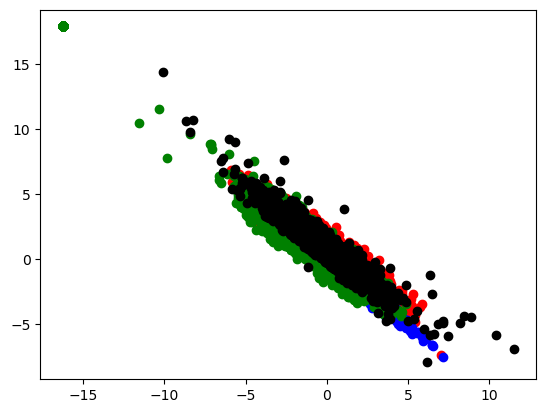

In [65]:
plt.scatter(df['Feature1'],df['Feature2'],c='r')
plt.scatter(df['Feature3'],df['Feature4'],c='b')
plt.scatter(df['Feature5'],df['Feature6'],c='g')
plt.scatter(df['Feature7'],df['Feature8'],c='k')

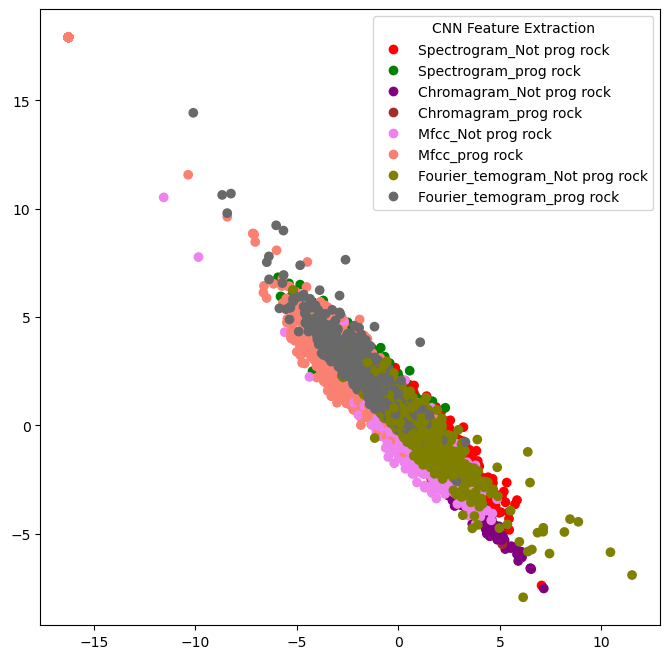

In [95]:
import matplotlib
fig = plt.figure(figsize=(8,8))
labels = ['Spectrogram_Not prog rock','Spectrogram_prog rock',
         'Chromagram_Not prog rock','Chromagram_prog rock',
         'Mfcc_Not prog rock','Mfcc_prog rock',
         'Fourier_temogram_Not prog rock','Fourier_temogram_prog rock']
colors = ['red','green']
scatter_spectrogram = plt.scatter(df['Feature1'],df['Feature2'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
colors = ['purple','brown']
scatter_chromagram = plt.scatter(df['Feature3'],df['Feature4'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
colors = ['violet','salmon']
scatter_mfcc = plt.scatter(df['Feature5'],df['Feature6'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
colors = ['olive','dimgray']
scatter_fourier = plt.scatter(df['Feature7'],df['Feature8'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter_spectrogram.legend_elements()[0]
           +scatter_chromagram.legend_elements()[0]
           +scatter_mfcc.legend_elements()[0]
           +scatter_fourier.legend_elements()[0], 
           labels=labels,
           title="CNN Feature Extraction")
plt.show()

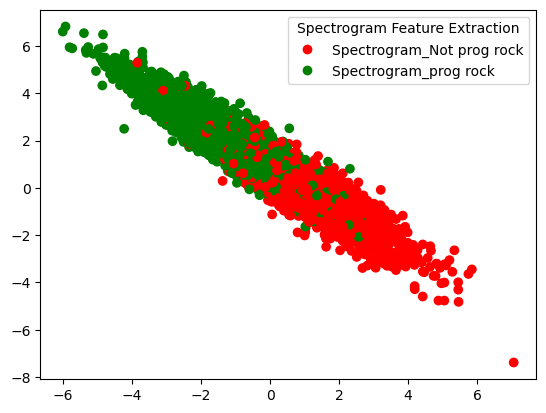

In [96]:
colors = ['red','green']
labels = ['Spectrogram_Not prog rock','Spectrogram_prog rock']
scatter_spectrogram = plt.scatter(df['Feature1'],df['Feature2'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter_spectrogram.legend_elements()[0], 
           labels=labels,
           title="Spectrogram Feature Extraction")
plt.show()

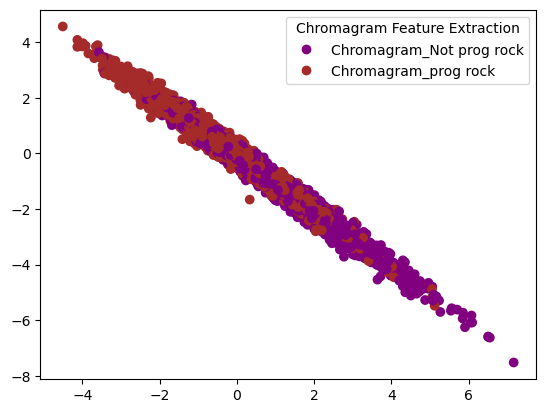

In [97]:
colors = ['purple','brown']
labels = ['Chromagram_Not prog rock','Chromagram_prog rock']
scatter_chromagram = plt.scatter(df['Feature3'],df['Feature4'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter_chromagram.legend_elements()[0], 
           labels=labels,
           title="Chromagram Feature Extraction")
plt.show()

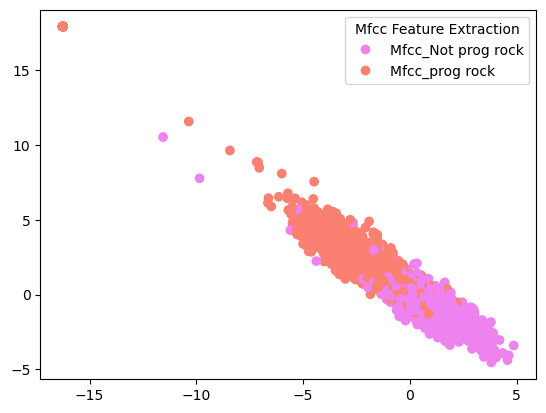

In [99]:
colors = ['violet','salmon']
labels = ['Mfcc_Not prog rock','Mfcc_prog rock']
scatter_mfcc = plt.scatter(df['Feature5'],df['Feature6'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter_mfcc.legend_elements()[0], 
           labels=labels,
           title="Mfcc Feature Extraction")
plt.show()

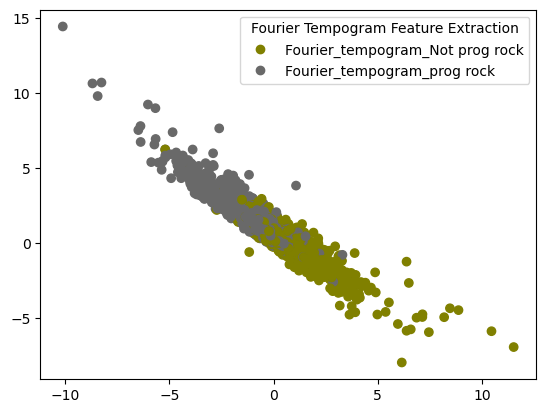

In [100]:
colors = ['olive','dimgray']
labels = ['Fourier_tempogram_Not prog rock','Fourier_tempogram_prog rock']
scatter_fourier_tempogram = plt.scatter(df['Feature7'],df['Feature8'], c=df['label'], cmap=matplotlib.colors.ListedColormap(colors))
plt.legend(handles=scatter_fourier_tempogram.legend_elements()[0], 
           labels=labels,
           title="Fourier Tempogram Feature Extraction")
plt.show()

# SVM meta classifier

In [102]:
X=np.array(df.iloc[:,:-1])
y=np.array(df.iloc[:,-1])

In [103]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5,shuffle=True,stratify=y,random_state=37)

In [104]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [105]:
clf=LinearSVC(C=0.01,max_iter=1000)

In [106]:
clf.fit(X_train,y_train)

LinearSVC(C=0.01)

In [107]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)
print("Train Set Accuracy")      
print("Accuracy on train set is {:.2f}".format(accuracy_score(y_pred_train,y_train)))
print('----------')
print("Test Set Accuracy")      
print("Accuracy on test set is {:.2f}".format(accuracy_score(y_pred_test,y_test)))

In [108]:
print("Train Set Accuracy")      
print("Accuracy on train set is {:.2f}".format(accuracy_score(y_pred_train,y_train)))
print('----------')
print("Test Set Accuracy")      
print("Accuracy on test set is {:.2f}".format(accuracy_score(y_pred_test,y_test)))

Train Set Accuracy
Accuracy on train set is 0.93
----------
Test Set Accuracy
Accuracy on test set is 0.94


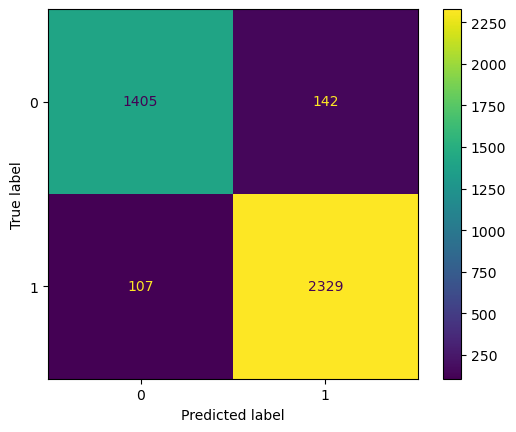

In [109]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_pred_test))
cm_display.plot()
plt.show()

In [112]:
cm=confusion_matrix(y_test,y_pred_test)
accuracies = [0 for i in range(2)]
for i in range(2):
    row_sum=0
    for j in range(2):
        row_sum+=cm[i][j]
    accuracies[i]=(cm[i][i]/row_sum)*100
for i in range(2):
    print("Accuracy of {output_label} is: {acc}%".format(output_label=output_label(i),acc=accuracies[i]))

Accuracy of Not Prog Rock is: 90.82094376212024%
Accuracy of Prog rock is: 95.60755336617406%


In [114]:
#Performing KFold Cross Validation
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,random_state=37,shuffle=True)
val_accuracies=[]
for train_index,val_index in skf.split(X_train,y_train):
    X_train_split,X_val_split=X_train[train_index],X_train[val_index]
    y_train_split,y_val_split=y_train[train_index],y_train[val_index]
    clf=LinearSVC(C=0.01,max_iter=1000)
    clf.fit(X_train_split,y_train_split)
    val_accuracies.append(np.mean(clf.predict(X_val_split)==y_val_split))
#print(len(test_accuracies))
print("Maximum accuracy acheived with K-Fold Cross validation is {}".format(max(val_accuracies)))

Maximum accuracy acheived with K-Fold Cross validation is 0.9372647427854455
